In [1]:
!pip install yfinance --quiet

In [2]:
#패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### 서재경의 포트폴리오

| Ticker | Sector |
| ------ | -----  |
| SPY | 미국 주식 |
| VEA | 선진국 주식 |
| VWO | 개발도상국 주식 |
| XLK | IT |
| XLV | 헬스케어 |
| XLI | 산업재 |
| LQD | 미국 회사채 |
| TLT | 미국 장기채 |
| BIL | 미국 초단기채 |
| GLD |  금  |



### 1. 포트폴리오  
(주식)  
SPY = S&P500 지수를 추종하는 ETF  
VEA = 미국 제외 선진국 주식의 지수를 추종하는 ETF  
VWO = 개발도상국 주식 ETF  
XLK, XLV, XLI = 미국 IT, 헬스케어, 산업재 섹터 ETF  
(채권)  
LQD = 미국 회사채, TLT = 미국 장기채 (20years+)  
BIL = 미국 초단기채 (1~3개월 채권) = 현금 대용  
(금)  
GLD  

#### 포트폴리오 구성 논리  
10개 자산 중 6개는 높은 수익을 위해 주식에 투자하고, 4개는 주식의 변동성을 헤지하기 위해 채권 2개, 현금 1개, 금 1개에 투자한다.  
주식은 국가별 자산배분을 위해 미국 SPY, 미국 제외 선진국 VEA, 개발도상국 VWO 에 투자하고,  
국가별 자산배분으로 수익이 낮아진 것을 보완하기 위해 고수익, 고변동성 섹터인 IT, 헬스케어, 산업재 섹터에 투자한다.  
그리고 원금 보장을 위해 현금을 대체할 수 있는 BIL에 투자하고, 주식이 하락할 때 상승하는 경향을 보이는 금에 투자한다.  
현금과 금에서 헤지를 충분히 했기 때문에 채권 2개는 비교적 수익과 변동성이 다른 채권들보다 높은 LQD와 TLT에 투자한다.  

In [3]:
tickers = ['SPY', 'VEA', 'VWO', 'XLK', 'XLV', 'XLI', 'LQD', 'TLT', 'BIL', 'GLD']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01',actions= False)['Close']
data = data.resample('3M').last()

[*********************100%***********************]  10 of 10 completed


### Normalization to 100:

$$
\frac {P_t}{P_0} * 100
$$

In [4]:
#데이터가 어떻게 생겼는지 확인해보기 위해 plot graph 만들어보자!
P0 =  data.iloc[0]

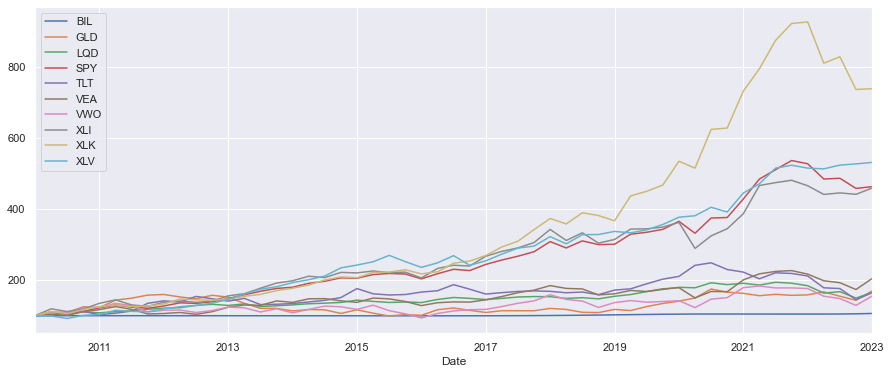

In [5]:
#The idea behind this operation is to compare the behavior of the four different stocks as if they were all starting from the same value = 100
(data / data.iloc[0] * 100).plot(figsize = (15, 6));
plt.show()

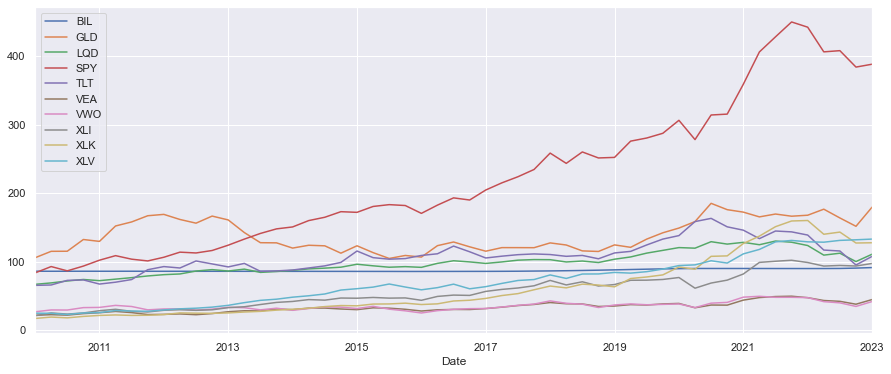

In [6]:
#만약 정규화를 시켜주지 않고 그냥 그래프로 표현한다면?
data.plot(figsize=(15,6))
plt.show()

##포트폴리오 수익률 계산

###Simple rate of return

$$
\frac{P_1 - P_0}{P_0} = \frac{P_1}{P_0} - 1
$$

In [7]:
data

,BIL,GLD,LQD,SPY,TLT,VEA,VWO,XLI,XLK,XLV
Date,,,,,,,,,,
2010-01-31 00:00:00-05:00,86.303902,105.959999,67.150177,83.818016,65.647446,21.947113,27.046715,21.240736,17.287275,25.047728
2010-04-30 00:00:00-04:00,86.247475,115.360001,69.226395,93.113197,66.205132,22.850248,29.748560,25.353584,19.352894,24.810202
2010-07-31 00:00:00-04:00,86.266296,115.489998,72.050003,86.831436,72.925011,22.164606,29.614170,23.694740,18.200775,23.070923
2010-10-31 00:00:00-04:00,86.285080,132.619995,74.249992,93.803749,73.608177,24.384457,33.150627,25.301508,20.291561,25.299932
2011-01-31 00:00:00-05:00,86.266296,129.869995,72.527985,102.406532,67.540726,25.691000,33.453678,28.639273,21.736090,25.847263
2011-04-30 00:00:00-04:00,86.266296,152.369995,74.741142,109.045769,70.281754,27.571331,36.411175,30.717657,22.438913,28.882816
2011-07-31 00:00:00-04:00,86.285080,158.289993,76.911354,103.883377,74.133102,25.866386,34.770519,27.663305,21.745226,28.101910
2011-10-31 00:00:00-04:00,86.228638,167.339996,79.387581,101.328522,88.512207,23.013224,29.884514,26.807451,21.997110,27.789639
2012-01-31 00:00:00-05:00,86.213600,169.309998,81.269936,106.700050,93.074516,23.289749,31.186731,29.248129,22.959774,29.810755


In [11]:
#수익률 계산
rets = data.pct_change().fillna(0)

In [12]:
rets

,BIL,GLD,LQD,SPY,TLT,VEA,VWO,XLI,XLK,XLV
Date,,,,,,,,,,
2010-01-31 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-04-30 00:00:00-04:00,-0.000654,0.088713,0.030919,0.110897,0.008495,0.041151,0.099896,0.193630,0.119488,-0.009483
2010-07-31 00:00:00-04:00,0.000218,0.001127,0.040788,-0.067464,0.101501,-0.030006,-0.004518,-0.065428,-0.059532,-0.070103
2010-10-31 00:00:00-04:00,0.000218,0.148325,0.030534,0.080297,0.009368,0.100153,0.119418,0.067811,0.114873,0.096616
2011-01-31 00:00:00-05:00,-0.000218,-0.020736,-0.023192,0.091710,-0.082429,0.053581,0.009142,0.131920,0.071189,0.021634
2011-04-30 00:00:00-04:00,0.000000,0.173250,0.030515,0.064832,0.040583,0.073190,0.088406,0.072571,0.032334,0.117442
2011-07-31 00:00:00-04:00,0.000218,0.038853,0.029036,-0.047342,0.054799,-0.061838,-0.045059,-0.099433,-0.030914,-0.027037
2011-10-31 00:00:00-04:00,-0.000654,0.057174,0.032196,-0.024593,0.193963,-0.110304,-0.140521,-0.030938,0.011583,-0.011112
2012-01-31 00:00:00-05:00,-0.000174,0.011772,0.023711,0.053011,0.051544,0.012016,0.043575,0.091045,0.043763,0.072729


##변동성

In [13]:
#색깔 팔레트
pal = sns.color_palette('Spectral',len(tickers))

In [14]:
#가중치 계산 함수
def get_ew_weights(rets):
  noa = len(rets.columns)
  weights = np.ones_like(rets) * (1/noa)
  return weights

weights = get_ew_weights(rets)[-1]
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

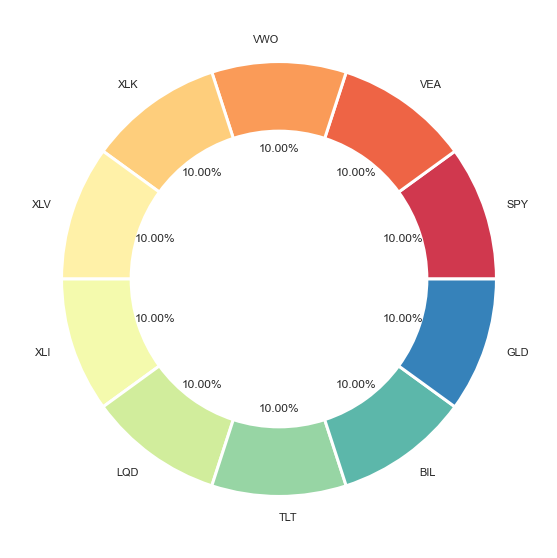

In [15]:
# 파이차트 시각화
plt.figure(figsize=(10, 10))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(weights, labels=tickers, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

Text(0, 0.5, 'Weights')

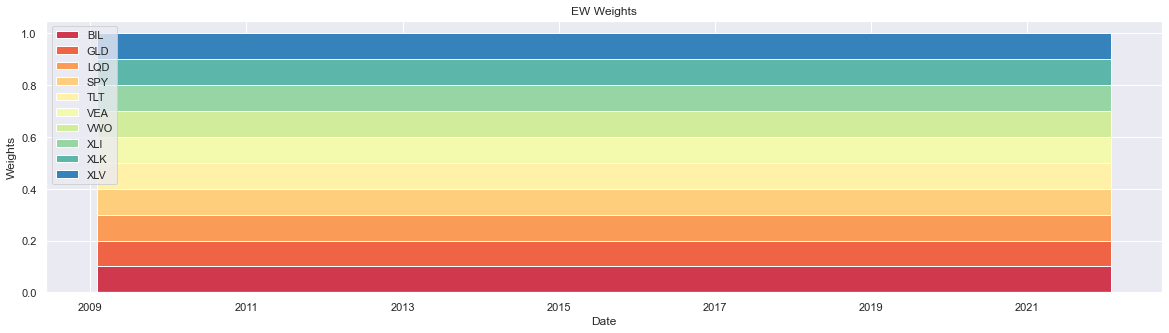

In [16]:
# 시계열 가중치 데이터프레임
ew_w_df = pd.DataFrame(get_ew_weights(rets), index=rets.index, columns=rets.columns)

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.stackplot(ew_w_df.index, ew_w_df.T, labels=ew_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('EW Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

### 2. 백테스팅

[*********************100%***********************]  10 of 10 completed
총 수익률: 178.173%


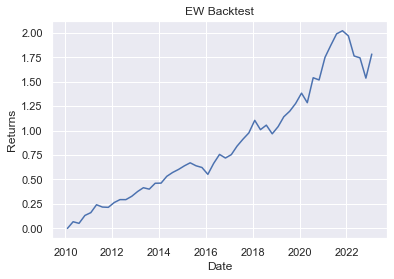

In [13]:
tickers = ['SPY', 'VEA', 'VWO', 'XLK', 'XLV', 'XLI', 'LQD', 'TLT', 'BIL', 'GLD']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01',actions= False)['Close']
data = data.resample('3M').last()

#수익률 계산
rets = data.pct_change().fillna(0)

#가중치 계산 함수
def get_ew_weights(rets):
  noa = len(rets.columns)
  weights = np.ones_like(rets) * (1/noa)
  return weights

weights = get_ew_weights(rets)[-1]

port_rets = rets.mean(axis =1)

# 포트폴리오 누적 수익률
port_cum_rets = (1 + port_rets).cumprod() - 1
# 총 수익률
port_cum_rets_end = str(round(port_cum_rets[-1] * 100, 3))

# 그래프 결과
plt.plot(port_cum_rets)
plt.title('EW Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')
print('총 수익률: ' + port_cum_rets_end + '%')

### 3. 수익률 개선방안
안전자산 중 주식과 역상관관계를 보이는 금을 제외하고 모두 주식에 투자한다.  
채권 LQD, TLT 에 20% 투자 -> 유틸리티 XLU, 필수소비재 XLP 에 20% 투자  
현금 BIL 투자 -> 금융 XLF 투자


### 개선 후 백테스팅

[*********************100%***********************]  10 of 10 completed
총 수익률: 275.923%


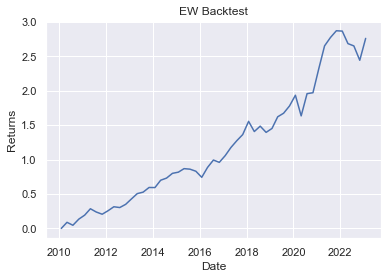

In [14]:
tickers = ['SPY', 'VEA', 'VWO', 'XLK', 'XLV', 'XLI', 'XLU', 'XLP', 'XLF', 'GLD']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01',actions= False)['Close']
data = data.resample('3M').last()

#수익률 계산
rets = data.pct_change().fillna(0)

#가중치 계산 함수
def get_ew_weights(rets):
  noa = len(rets.columns)
  weights = np.ones_like(rets) * (1/noa)
  return weights

weights = get_ew_weights(rets)[-1]

port_rets = rets.mean(axis =1)

# 포트폴리오 누적 수익률
port_cum_rets = (1 + port_rets).cumprod() - 1
# 총 수익률
port_cum_rets_end = str(round(port_cum_rets[-1] * 100, 3))

# 그래프 결과
plt.plot(port_cum_rets)
plt.title('EW Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')
print('총 수익률: ' + port_cum_rets_end + '%')